# STM Transit Delay Data Preparation

## Overview

This notebook merges data from different sources and prepares it for data analysis and preprocessing.

## Data description

### Real-time Trip Updates

`current_time`: Timestamp when the data was fetched from the GTFS, in microseconds.<br>
`trip_id`: Unique identifier for the transit trip.<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`start_date`: Start date of the transit trip.<br>
`stop_id`: Unique identifier of a stop.<br>
`arrival_time`, `departure_time`: Realtime arrival and departure time, in microseconds<br>
`schedule_relationship`: State of the trip, 0 meaning "scheduled" and 1 meaning "skipped".

### Scheduled STM Trips

`trip_id`: Unique identifier for the transit trip.<br>
`arrival_time`, `departure_time`: Scheduled arrival and departure time.<br>
`stop_id`: Unique identifier of a stop.<br>
`stop_sequence`: Sequence of a stop, for ordering.

### STM Stops

`stop_id`: Unique identifier of a stop.<br>
`stop_code`: Bus stop or metro station number.<br>
`stop_name`: Bus stop or metro station name<br>
`stop_lat`, `stop_lon`: Stop coordinates.<br>
`stop_url`: Stop web page.<br>
`location_type`: Stop type.<br>
`parent_station`: Parent station (metro station with multiple exits).<br>
`wheelchair_boarding`: Indicates if the stop is accessible for people in wheelchair, 1 being true and 2 being false.

### Real-time Vehicle Positions

`current_time`: Timestamp when the data was fetched from the GTFS, in microseconds.<br>
`vehicle_id`: Unique identifier for a vehicle.<br>
`trip_id`: Unique identifier for the transit trip.<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`start_date`: Start date of a transit trip.<br>
`start_time`: Start time of a transit trip.<br>
`latitude`, `longitude`: Vehicle current position.<br>
`bearing`: Direction that the vehicle is facing.<br>
`speed`: Momentary speed measured by the vehicle, in meters per second.<br>
`stop_sequence`: Sequence of a stop, for ordering.<br>
`status`: Vehicle stop status in relation with a stop that it's currently approaching or is at, 1 being "stopped at" and 2 being "in transit to".<br>
`timestamp`: Timestamp when STM updated the data, in milliseconds.<br>
`occupancy_status`: Degree of passenger occupancy, ranging from 1 (empty) to 7 (not accepting passengers).

### Weather Archive and Forecast

`time`: Date and hour or the weather.<br>
`temperature`: Air temperature at 2 meters above ground, in Celsius.<br>
`precipitation`: Total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters.<br>
`windspeed`: Wind speed at 10 meters above ground, in kilometers per hour.<br>
`weathercode`: World Meteorological Organization (WMO) code, see [Open-Meteo API documentation](https://open-meteo.com/en/docs#weather_variable_documentation) for the list.

### Traffic Incidents

`category`: Category of the incident.<br>
`start_time`: Start time of the incident, in ISO8601 format.<br>
`end_time`: End time of the incident, in ISO8601 format.<br>
`length`: Length of the incident in meters.<br>
`delay`: Delay in seconds caused by the incident (except road closures).<br>
`magnitude_of_delay`: Severity of the delay, ranging from 0 to 4 (minor to major).<br>
`last_report_time`: Date when the last time the incident was reported,in ISO8601 format.<br>
`latitude`, `longitude`: Coordinates of the incident.

## Imports

In [1]:
from datetime import datetime, timedelta, timezone
from haversine import haversine, Unit
import matplotlib.pyplot as plt
import pandas as pd
import sys

In [2]:
# Import custom code
sys.path.insert(0, '..')
from scripts.custom_functions import fetch_weather, LOCAL_TIMEZONE

In [3]:
# Import data
trips_df = pd.read_csv('../data/api/fetched_stm_trip_updates.csv', low_memory=False)
schedules_df = pd.read_csv('../data/download/stop_times_2025-04-30.txt')
stops_df = pd.read_csv('../data/download/stops_2025-04-30.txt')
positions_df =  pd.read_csv('../data/api/fetched_stm_vehicle_positions.csv', low_memory=False)
weather_df = pd.read_csv('../data/api/fetched_historical_weather.csv')
traffic_df = pd.read_csv('../data/api/fetched_traffic.csv')


## Clean Data

In [4]:
# Convert route_id to integer
trips_df['route_id'] = trips_df['route_id'].str.extract(r'(\d+)')
trips_df['route_id'] = trips_df['route_id'].astype('int64')

In [5]:
# Sort trips
trips_df = trips_df.sort_values(by=['current_time', 'trip_id', 'route_id', 'arrival_time'])

In [6]:
# Get proportion of duplicates
subset = ['start_date', 'trip_id', 'route_id', 'stop_id']
duplicate_mask = trips_df.duplicated(subset=subset)
print(f'{duplicate_mask.mean():.2%}')

25.95%


In [7]:
# Remove duplicates
trips_df = trips_df.drop_duplicates(subset=subset, keep='last') # keep latest update

In [ ]:
# Convert realtime arrival and departure time to microseconds
trips_df['arrival_time'] = trips_df['arrival_time'] * 1000
trips_df['departure_time'] = trips_df['departure_time'] * 1000

In [9]:
# Get distribution of realtime arrival times
trips_df[['arrival_time', 'departure_time']].describe()

,arrival_time,departure_time
count,2.154171e+06,2.154171e+06
mean,1.645630e+12,1.641982e+12
std,4.063282e+11,4.131909e+11
min,0.000000e+00,0.000000e+00
25%,1.745868e+12,1.745867e+12
50%,1.745950e+12,1.745950e+12
75%,1.746031e+12,1.746031e+12
max,1.746123e+12,1.746123e+12


In [10]:
# Get proportion of rows with zero arrival times
zero_mask = trips_df['arrival_time'] == 0
print(f'{zero_mask.mean():.2%}')

5.75%


In [11]:
# Get proportion of rows where the arrival and departure times are different
diff_date_mask = trips_df['arrival_time'] != trips_df['departure_time']
print(f'{diff_date_mask.mean():.2%}')

6.08%


In [12]:
# Display rows
trips_df[diff_date_mask].sample(10)

,current_time,trip_id,route_id,start_date,stop_id,arrival_time,departure_time,schedule_relationship
2466807,1.746050e+09,286573236,190,20250430,57115,0,1746051420000,0
1009071,1.745921e+09,285283541,74,20250429,54356,0,1745921700000,0
2622475,1.746072e+09,285008027,177,20250430,60284,1746073500000,0,0
1142940,1.745928e+09,284777541,105,20250429,50741,0,1745929080000,0
308595,1.745842e+09,285007422,164,20250428,54127,1745842380000,0,0
707230,1.745874e+09,284741095,19,20250428,50769,1745875200000,0,0
2884220,1.746115e+09,286573376,195,20250501,57365,0,1746115620000,0
2697276,1.746101e+09,285283545,74,20250501,61555,1746101760000,0,0
2136795,1.746029e+09,284727023,129,20250430,59308,1746029591000,1746029856000,0
1951475,1.746011e+09,284778273,124,20250430,61371,0,1746011280000,0


In [13]:
# Replace zero arrival times by departure times, as they are usually the same
trips_df.loc[zero_mask, 'arrival_time'] = trips_df.loc[zero_mask, 'departure_time']

In [14]:
# Get proportion of rows with zero arrival times again
zero_mask = trips_df['arrival_time'] == 0
print(f'{zero_mask.mean():.2%}')

3.20%


In [15]:
# Delete the rows with 0 arrival times
trips_df = trips_df[~zero_mask]
zero_mask = trips_df['arrival_time'] == 0
assert zero_mask.sum() == 0

In [16]:
# Rename arrival time
trips_df = trips_df.rename(columns={'arrival_time': 'realtime_arrival_time'})

## Merge Data

### Realtime and Scheduled Trips

In [17]:
# Sort values by stop sequence
schedules_df = schedules_df.sort_values(by=['trip_id', 'stop_sequence'])

In [18]:
# Reset stop sequences (some stops might be missing)
schedules_df['stop_sequence'] = schedules_df.groupby('trip_id').cumcount() + 1

In [19]:
# Add trip progress (vehicles further along the trip are more likely to be delayed)
total_stops = schedules_df.groupby('trip_id')['stop_id'].transform('count')
schedules_df['trip_progress'] = schedules_df['stop_sequence'] / total_stops

In [20]:
# Merge realtime and scheduled trips
stm_trips_df = pd.merge(left=trips_df, right=schedules_df, how='inner', on=['trip_id', 'stop_id'])

In [21]:
# Convert start_date to datetime
stm_trips_df['start_date_dt'] = pd.to_datetime(stm_trips_df['start_date'], format='%Y%m%d')

In [22]:
def parse_gtfs_time(row) -> pd.Timestamp:
	'''
	Converts GTFS time string (e.g., '25:30:00') to datetime
	based on the arrival time.
	'''
	hours, minutes, seconds = map(int, row['arrival_time'].split(':'))
	total_seconds = hours * 3600 + minutes * 60 + seconds

	parsed_time = row['start_date_dt'] + timedelta(seconds=total_seconds)
	return parsed_time

In [23]:
# Convert planned arrival time to datetime
parsed_time = stm_trips_df.apply(parse_gtfs_time, axis=1)
sch_arrival_time_local = parsed_time.dt.tz_localize(LOCAL_TIMEZONE)

In [24]:
# Convert realtime and arrival time to UTC datetime
stm_trips_df['realtime_arrival_time'] = pd.to_datetime(stm_trips_df['realtime_arrival_time'], origin='unix', unit='ms', utc=True)
stm_trips_df['scheduled_arrival_time'] = sch_arrival_time_local.dt.tz_convert(timezone.utc)

In [25]:
# Calculate delay in seconds (real - scheduled)
stm_trips_df['delay'] = (stm_trips_df['realtime_arrival_time'] - stm_trips_df['scheduled_arrival_time']) / pd.Timedelta(seconds=1)

In [26]:
# Get distribution
stm_trips_df['delay'].describe()

count    2.067055e+06
mean     7.134723e+01
std      4.350771e+02
min     -1.359200e+04
25%      0.000000e+00
50%      0.000000e+00
75%      3.300000e+01
max      5.458500e+04
Name: delay, dtype: float64

There are some extreme delays (~2h15min early to ~5h15min late), which could greatly affect the performance of a predictive model.

### Trips and Stops

In [27]:
trips_stops_df = pd.merge(left=stm_trips_df, right=stops_df, how='inner', left_on='stop_id', right_on='stop_code')

In [28]:
trips_stops_df.columns

Index(['current_time', 'trip_id', 'route_id', 'start_date', 'stop_id_x',
       'realtime_arrival_time', 'departure_time_x', 'schedule_relationship',
       'arrival_time', 'departure_time_y', 'stop_sequence', 'trip_progress',
       'start_date_dt', 'scheduled_arrival_time', 'delay', 'stop_id_y',
       'stop_code', 'stop_name', 'stop_lat', 'stop_lon', 'stop_url',
       'location_type', 'parent_station', 'wheelchair_boarding'],
      dtype='object')

In [29]:
# Rename stop id
trips_stops_df = trips_stops_df.rename(columns={'stop_id_x': 'stop_id'})

In [30]:
# Convert wheelchair_boarding to boolean
trips_stops_df['wheelchair_boarding'] = (trips_stops_df['wheelchair_boarding'] == 1).astype('int64')

### Vehicle Positions

In [31]:
# Rename latitude and longitude
positions_df = positions_df.rename(columns={
  'latitude': 'vehicle_lat',
  'longitude': 'vehicle_lon',
  'status': 'vehicle_status',
  'bearing': 'vehicle_bearing',
  'speed': 'vehicle_speed'
})

In [32]:
# Convert vehicle timestamp to datetime
positions_df['vehicle_dt'] = pd.to_datetime(positions_df['timestamp'] * 1000, origin='unix', unit='ms', utc=True)

In [33]:
# Sort values
subset = ['trip_id', 'route_id', 'start_date', 'stop_sequence']
positions_df = positions_df.sort_values(by=subset)

In [34]:
# Get duplicates
duplicate_mask = positions_df.duplicated(subset=subset)
positions_df[duplicate_mask]

,current_time,vehicle_id,trip_id,route_id,start_date,start_time,vehicle_lat,vehicle_lon,vehicle_bearing,vehicle_speed,stop_sequence,vehicle_status,timestamp,occupancy_status,vehicle_dt
136494,1.746045e+09,31001,904429,470,20250430.0,16:03:00,45.489998,-73.729767,284.0,14.44456,2,2,1746045054,3,2025-04-30 20:30:54+00:00
104926,1.746009e+09,41042,905002,41,20250430.0,05:30:00,45.555935,-73.667336,0.0,0.00000,35,2,1746009039,1,2025-04-30 10:30:39+00:00
56821,1.745929e+09,33829,908894,470,20250429.0,07:15:00,45.496933,-73.704300,41.0,3.88892,24,2,1745928932,3,2025-04-29 12:15:32+00:00
15261,1.745852e+09,32802,914104,470,20250428.0,10:24:00,45.459759,-73.891930,144.0,0.00000,3,1,1745852444,1,2025-04-28 15:00:44+00:00
15784,1.745853e+09,32802,914104,470,20250428.0,10:24:00,45.459759,-73.891930,94.0,0.00000,3,1,1745853345,1,2025-04-28 15:15:45+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110747,1.746014e+09,42026,286749881,69,20250430.0,07:58:00,45.568249,-73.659622,0.0,0.00000,5,2,1746014441,1,2025-04-30 12:00:41+00:00
55689,1.745928e+09,39136,287230574,56,20250429.0,07:29:00,45.618084,-73.581253,0.0,0.00000,16,2,1745928023,1,2025-04-29 12:00:23+00:00
56793,1.745929e+09,39136,287230574,56,20250429.0,07:29:00,45.618450,-73.580353,0.0,0.00000,16,2,1745928937,1,2025-04-29 12:15:37+00:00
57850,1.745930e+09,39136,287230574,56,20250429.0,07:29:00,45.617733,-73.580452,0.0,0.00000,16,2,1745929818,1,2025-04-29 12:30:18+00:00


In [35]:
# Get proportion of duplicates
print(f'{duplicate_mask.mean():.2%}')

3.38%


In [36]:
# Remove duplicates
positions_df = positions_df.drop_duplicates(subset=subset)

In [37]:
# Merge with other STM data
stm_df = pd.merge(left=trips_stops_df, right=positions_df, how='inner', on=['trip_id', 'route_id', 'start_date', 'stop_sequence'])

In [38]:
# Calculate distance between the vehicle and the stop
stm_df['vehicle_distance'] = stm_df.apply(
  lambda row: haversine((row['vehicle_lat'], row['vehicle_lon']), (row['stop_lat'], row['stop_lon']), unit=Unit.METERS),
  axis=1)

### STM and Weather

In [39]:
# Convert time string to datetime
time_dt = pd.to_datetime(weather_df['time'], utc=True)

In [40]:
# Calculate dates for weather forecast
last_day_weather = time_dt.max()
start_date = last_day_weather + timedelta(days=1)
end_date = stm_df['realtime_arrival_time'].max()

In [41]:
# Fetch forecast weather
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

forecast_list = fetch_weather(start_date=start_date_str, end_date=end_date_str, forecast=True)
forecast_df = pd.DataFrame(forecast_list)

In [42]:
# Merge archive and forecast weather
weather_df = pd.concat([weather_df, forecast_df], ignore_index=True)

In [43]:
# Round arrival time to the nearest hour
rounded_arrival_dt = stm_df['realtime_arrival_time'].dt.round('h')

In [44]:
# Format time to match weather data
stm_df['time'] = rounded_arrival_dt.dt.strftime('%Y-%m-%dT%H:%M')

In [45]:
# Merge STM with weather
stm_weather_df = pd.merge(left=stm_df, right=weather_df, how='inner', on='time')

### Traffic Data

In [46]:
# Get proportion of duplicates
duplicate_mask = traffic_df.duplicated()
print(f'{duplicate_mask.mean():.2%}')

33.57%


In [47]:
# Remove duplicates
traffic_df = traffic_df.drop_duplicates(keep='last').reset_index()

In [48]:
# Convert traffic start_time and end_time to datetime
traffic_df['start_time'] = pd.to_datetime(traffic_df['start_time'], utc=True)
traffic_df['end_time'] = pd.to_datetime(traffic_df['end_time'], utc=True)

In [49]:
# Sort by date
traffic_df = traffic_df.sort_values(by='start_time').reset_index()

In [50]:
# Fill null end times with current time (assuming the incident is still ongoing)
traffic_df['end_time'] = traffic_df['end_time'].fillna(datetime.now(timezone.utc).replace(microsecond=0))
assert traffic_df['end_time'].isna().sum() == 0

In [51]:
# Build traffic cache (for every 30 min interval)
def build_traffic_cache(traffic_df:pd.DataFrame) -> dict:
	traffic_cache = {}
	traffic_df['half_hour'] = traffic_df['start_time'].dt.floor('15min')

	for (hour, group) in traffic_df.groupby('half_hour'):
		traffic_cache[hour] = group.copy()

	return traffic_cache

Since there are many trip updates on the same day (even the same hour), there's a risk of repeating the filtering of active traffic incidents for each trip individually, which takes a lot of time for a large dataset. Traffic incidents are stable over minutes or hours. This is why the incidents will be cached by 15 minute intervals.

In [52]:
def calculate_nearby_incidents(trip_update:pd.Series, traffic_cache:dict, max_distance:int=500) -> pd.Series:
	trip_datetime = trip_update['vehicle_dt']
	stop_coords = (trip_update['vehicle_lat'], trip_update['vehicle_lon'])

	trip_half_hour = trip_datetime.floor('15min')

	# Get cached incidents
	hour_incidents = traffic_cache.get(trip_half_hour)

	# Stop if there are no incidents for that hour
	if hour_incidents is None or hour_incidents.empty:
		return pd.Series({
			'incident_nearby': 0,
			'nearest_incident_distance': None,
			'incident_category': None,
			'incident_delay': None,
			'incident_delay_magnitude': None
		})

	# Filter for active incidents at that trip hour
	active_incidents = hour_incidents[
		(hour_incidents['start_time'] <= trip_datetime) &
		(hour_incidents['end_time'] >= trip_datetime)
	].copy()

	if active_incidents.empty:
		return pd.Series({
			'incident_nearby': 0,
			'nearest_incident_distance': None,
			'incident_category': None,
			'incident_delay': None,
			'incident_delay_magnitude': None
		})

	# Calculate distance     
	active_incidents['distance'] = active_incidents.apply(
		lambda row: haversine(stop_coords, (row['latitude'], row['longitude']), unit=Unit.METERS),
		axis=1
	)

	# Filter nearby
	nearby_incidents = active_incidents[active_incidents['distance'] <= max_distance]

	if nearby_incidents.empty:
		return pd.Series({
			'incident_nearby': 0,
			'nearest_incident_distance': None,
			'incident_category': None,
			'incident_delay': None,
			'incident_delay_magnitude': None
		})
	else:
		nearest = nearby_incidents.loc[nearby_incidents['distance'].idxmin()]
		return pd.Series({
			'incident_nearby': 1,
			'nearest_incident_distance': nearest['distance'],
			'incident_category': nearest['category'],
			'incident_delay': nearest['delay'],
			'incident_delay_magnitude': nearest['magnitude_of_delay']
		})

In [53]:
# Get traffic columns (get incidents within 500 meters)
traffic_cache = build_traffic_cache(traffic_df)
traffic_cols = stm_weather_df.apply(lambda row: calculate_nearby_incidents(row, traffic_cache), axis=1)

In [54]:
# Merge the traffic
df = pd.concat([stm_weather_df, traffic_cols], axis=1)

## Small EDA

In [55]:
# Get most correlated features with delay
correlations = df.drop(['current_time_x', 'current_time_y', 'departure_time_x', 'timestamp'], axis=1).corr(numeric_only=True)['delay']
correlations.sort_values(key=abs, ascending=False).head(11)[1:]

stop_sequence                0.099853
trip_progress                0.079836
occupancy_status             0.059604
route_id                     0.034740
nearest_incident_distance   -0.023170
vehicle_status               0.022744
incident_delay              -0.016081
precipitation               -0.012820
vehicle_id                   0.011051
vehicle_bearing              0.010309
Name: delay, dtype: float64

In [56]:
# Get proportion of trips that are on time
on_time_mask = df['delay'] == 0
print(f'{(on_time_mask.sum() / len(df)):.2%}')

63.74%


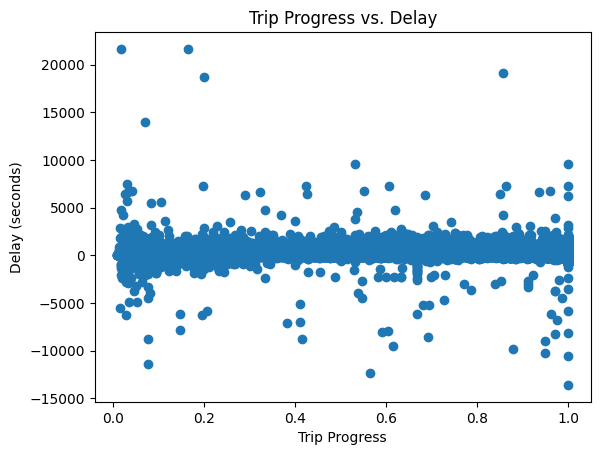

In [57]:
# Plot trip progress vs. delay
plt.scatter(x=df['trip_progress'], y=df['delay'])
plt.title('Trip Progress vs. Delay')
plt.xlabel('Trip Progress')
plt.ylabel('Delay (seconds)')
plt.savefig('../images/trip_progress_vs_delay.png', bbox_inches='tight')
plt.show()

From the plot, it looks like the delay is relatively stable across the trip progress. There are many data points that appear scattered around the x-axis, indicating that delays do not change significantly throughout the trip in many cases. The wide range of delays suggests that delays are highly variable, but there is not clear relationship between trip progress and delay. This could imply that other factors like traffic, accidents, mechanical issues or weather may have more impact on the delays.

## Export Data

In [58]:
# Remove columns with constant values or with more than 50% missing values
df = df.loc[:, (df.nunique() > 1) & (df.isna().mean() < 0.5)]
df.columns

Index(['current_time_x', 'trip_id', 'route_id', 'start_date', 'stop_id',
       'realtime_arrival_time', 'departure_time_x', 'arrival_time',
       'departure_time_y', 'stop_sequence', 'trip_progress', 'start_date_dt',
       'scheduled_arrival_time', 'delay', 'stop_id_y', 'stop_code',
       'stop_name', 'stop_lat', 'stop_lon', 'stop_url', 'wheelchair_boarding',
       'current_time_y', 'vehicle_id', 'start_time', 'vehicle_lat',
       'vehicle_lon', 'vehicle_bearing', 'vehicle_speed', 'vehicle_status',
       'timestamp', 'occupancy_status', 'vehicle_dt', 'vehicle_distance',
       'time', 'temperature', 'precipitation', 'windspeed', 'weathercode',
       'incident_nearby'],
      dtype='object')

In [59]:
# Keep relevant columns
df = df[[
  	'trip_id',
  	'vehicle_id', 
    'vehicle_lat',
    'vehicle_lon',
    'vehicle_distance', # engineered
    'vehicle_status',
    'vehicle_bearing',
    'vehicle_speed',
	'occupancy_status',
  	'route_id',
  	'stop_id',
    'stop_name',
  	'stop_lat',
  	'stop_lon',
	'stop_sequence',
  	'trip_progress', # engineered
  	'wheelchair_boarding',
  	'realtime_arrival_time',
    'scheduled_arrival_time',
    'delay', # engineered
  	'temperature',
  	'precipitation',
  	'windspeed', 
	'weathercode',
  	'incident_nearby', # engineered
	#'incident_category',
	#'nearest_incident_distance',
	#'incident_delay',
	#'incident_delay_magnitude'
]]

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155721 entries, 0 to 155720
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   trip_id                 155721 non-null  int64              
 1   vehicle_id              155721 non-null  int64              
 2   vehicle_lat             155721 non-null  float64            
 3   vehicle_lon             155721 non-null  float64            
 4   vehicle_distance        155721 non-null  float64            
 5   vehicle_status          155721 non-null  int64              
 6   vehicle_bearing         155721 non-null  float64            
 7   vehicle_speed           155721 non-null  float64            
 8   occupancy_status        155721 non-null  int64              
 9   route_id                155721 non-null  int64              
 10  stop_id                 155721 non-null  int64              
 11  stop_name               15

In [61]:
# Export data to CSV
df.to_csv('../data/stm_weather_traffic_merged.csv', index=False)

## End